In [49]:
from pathlib import Path
import librosa
import torch
from argparse import ArgumentParser
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
import tqdm
from IPython.display import Audio, display

import numpy as np

import sys
sys.path += ['../music-translation/src']

import utils
import wavenet_models
from utils import save_audio
from wavenet import WaveNet
from wavenet_generator import WavenetGenerator
from nv_wavenet_generator import NVWavenetGenerator
from nv_wavenet_generator import Impl

In [50]:
encoded = []
for directory in Path('encoded-musicnet/encoded').iterdir():
    for path in directory.iterdir():
        encoded += [torch.load(path)]
encoded = torch.cat(encoded, dim=0)

torch.Size([12800])
torch.Size([203])
torch.Size([12800, 203])


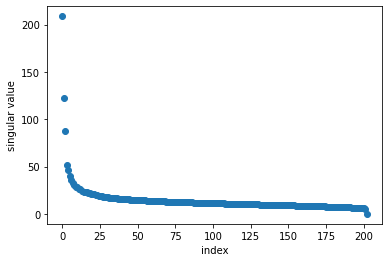

In [51]:
flattened = torch.flatten(encoded, 1)
col_means = torch.mean(flattened, 0)
print(col_means.shape)

demeaned = flattened - col_means
U, S, V = torch.svd(demeaned, compute_uv = True)
print(S.shape)
print(V.shape)


plt.scatter([i for i in range(203)], S.cpu().numpy())
plt.xlabel("index")
plt.ylabel("singular value")
plt.show()

In [52]:
principal_components = []

scaled = torch.matmul(torch.diag(S), torch.transpose(V, 0, 1))
remeaned = scaled + col_means

for i in range(3):
    principal_components += [torch.reshape(remeaned[i], (1,64,200))]

In [56]:
std_coeffs = torch.std(U, 0)
mean_coeffs = torch.mean(U, 0)
random_vectors = []
for i in range(3):
    random_coeffs = torch.normal(mean_coeffs, std_coeffs)
    random_vector = torch.chain_matmul(torch.reshape(random_coeffs, (1, 203)), torch.diag(S), torch.transpose(V, 0, 1))
    random_vector_remeaned = random_vector + col_means
    random_vectors.append(torch.reshape(random_vector_remeaned, (1,64,200)))

In [57]:
checkpoint = Path('../music-translation/checkpoints/pretrained_musicnet/bestmodel')
decoders = [0, 1, 2, 3, 4, 5]
batch_size = 1
rate = 16000
split_size = 20



def disp(x, decoder_ix):
    wav = utils.inv_mu_law(x.cpu().numpy())
    print(f'Decoder: {decoder_ix}')
    print(f'X min: {x.min()}, max: {x.max()}')

    display(Audio(wav.squeeze(), rate=rate))
        
def extract_id(path):
    decoder_id = str(path)[:-4].split('_')[-1]
    return int(decoder_id)



print('Starting')
matplotlib.use('agg')

checkpoints = checkpoint.parent.glob(checkpoint.name + '_*.pth')
checkpoints = [c for c in checkpoints if extract_id(c) in decoders]
assert len(checkpoints) >= 1, "No checkpoints found."

model_args = torch.load(checkpoint.parent / 'args.pth')[0]

decoders = []
decoder_ids = []
for checkpoint in checkpoints:
    decoder = WaveNet(model_args)
    decoder.load_state_dict(torch.load(checkpoint)['decoder_state'])
    decoder.eval()
    decoder = decoder.cuda()
    decoder = WavenetGenerator(decoder, batch_size, wav_freq=rate)
    
    decoders += [decoder]
    decoder_ids += [extract_id(checkpoint)]

Starting


In [19]:
#decoding principal components

yy = {}
with torch.no_grad():
    zz = []
    for vector in principal_components:
        zz += [vector]
    zz = torch.cat(zz, dim=0).float().cuda()
    print(zz.shape)

    with utils.timeit("Generation timer"):
        for i, decoder_id in enumerate(decoder_ids):
            yy[decoder_id] = []
            decoder = decoders[i]
            for zz_batch in torch.split(zz, batch_size):
                print(zz_batch.shape)
                splits = torch.split(zz_batch, split_size, -1)
                audio_data = []
                decoder.reset()
                for cond in tqdm.tqdm_notebook(splits):
                    audio_data += [decoder.generate(cond).cpu()]
                audio_data = torch.cat(audio_data, -1)
                yy[decoder_id] += [audio_data]
            yy[decoder_id] = torch.cat(yy[decoder_id], dim=0)

torch.Size([3, 64, 200])
torch.Size([1, 64, 200])


/home/wangjim19/virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Generating:   0%|          | 0/20 [00:00<?, ?it/s]../music-translation/src/wavenet_generator.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = F.softmax(prediction)
Generating: 100%|██████████| 20/20 [08:26<00:00, 25.34s/it]


torch.Size([1, 64, 200])


Generating: 100%|██████████| 20/20 [08:32<00:00, 25.64s/it]


torch.Size([1, 64, 200])


Generating: 100%|██████████| 20/20 [08:25<00:00, 25.27s/it]


torch.Size([1, 64, 200])


Generating: 100%|██████████| 20/20 [08:42<00:00, 26.14s/it]


torch.Size([1, 64, 200])


Generating: 100%|██████████| 20/20 [08:40<00:00, 26.00s/it]


torch.Size([1, 64, 200])


Generating: 100%|██████████| 20/20 [08:31<00:00, 25.58s/it]


torch.Size([1, 64, 200])


Generating: 100%|██████████| 20/20 [08:44<00:00, 26.21s/it]


torch.Size([1, 64, 200])


Generating: 100%|██████████| 20/20 [08:37<00:00, 25.87s/it]


torch.Size([1, 64, 200])


Generating: 100%|██████████| 20/20 [08:42<00:00, 26.12s/it]


torch.Size([1, 64, 200])


Generating: 100%|██████████| 20/20 [08:39<00:00, 25.96s/it]


torch.Size([1, 64, 200])


Generating: 100%|██████████| 20/20 [09:18<00:00, 27.93s/it]


torch.Size([1, 64, 200])


Generating: 100%|██████████| 20/20 [08:38<00:00, 25.91s/it]


torch.Size([1, 64, 200])


Generating: 100%|██████████| 20/20 [08:33<00:00, 25.69s/it]


torch.Size([1, 64, 200])


Generating: 100%|██████████| 20/20 [10:11<00:00, 30.59s/it]


torch.Size([1, 64, 200])


Generating: 100%|██████████| 20/20 [08:27<00:00, 25.36s/it]


torch.Size([1, 64, 200])


Generating: 100%|██████████| 20/20 [08:33<00:00, 25.66s/it]


torch.Size([1, 64, 200])


Generating: 100%|██████████| 20/20 [08:40<00:00, 26.05s/it]


torch.Size([1, 64, 200])


Generating: 100%|██████████| 20/20 [09:00<00:00, 27.03s/it]


Generation timer took 94638802.14047432 ms


In [21]:
for decoder_ix, decoder_result in yy.items():
    i=1
    for sample_result, principal_component in zip(decoder_result, principal_components):
        disp(sample_result, decoder_ix)
        wav = utils.inv_mu_law(sample_result.cpu().numpy())
        save_audio(wav.squeeze(), Path("results/principal_components_d" + str(decoder_ix) + "-" + str(i) + ".wav"), rate)
        i+=1

Decoder: 3
X min: 41, max: 224


Decoder: 3
X min: 34, max: 223


Decoder: 3
X min: 31, max: 220


Decoder: 2
X min: 72, max: 185


Decoder: 2
X min: 47, max: 206


Decoder: 2
X min: 47, max: 204


Decoder: 1
X min: 0, max: 242


Decoder: 1
X min: 0, max: 251


Decoder: 1
X min: 0, max: 253


Decoder: 0
X min: 62, max: 196


Decoder: 0
X min: 10, max: 244


Decoder: 0
X min: 10, max: 242


Decoder: 5
X min: 2, max: 254


Decoder: 5
X min: 1, max: 254


Decoder: 5
X min: 1, max: 252


Decoder: 4
X min: 0, max: 225


Decoder: 4
X min: 9, max: 244


Decoder: 4
X min: 14, max: 242


In [ ]:
#decoding randomly generated vectors

yy = {}
with torch.no_grad():
    zz = []
    for vector in random_vectors:
        zz += [vector]
    zz = torch.cat(zz, dim=0).float().cuda()
    print(zz.shape)

    with utils.timeit("Generation timer"):
        for i, decoder_id in enumerate(decoder_ids):
            yy[decoder_id] = []
            decoder = decoders[i]
            for zz_batch in torch.split(zz, batch_size):
                print(zz_batch.shape)
                splits = torch.split(zz_batch, split_size, -1)
                audio_data = []
                decoder.reset()
                for cond in tqdm.tqdm_notebook(splits):
                    audio_data += [decoder.generate(cond).cpu()]
                audio_data = torch.cat(audio_data, -1)
                yy[decoder_id] += [audio_data]
            yy[decoder_id] = torch.cat(yy[decoder_id], dim=0)

In [ ]:
for decoder_ix, decoder_result in yy.items():
    i=1
    for sample_result, random_vector in zip(decoder_result, random_vectors):
        disp(sample_result, decoder_ix)
        wav = utils.inv_mu_law(sample_result.cpu().numpy())
        save_audio(wav.squeeze(), Path("results/PCArandom_d" + str(decoder_ix) + "-" + str(i) + ".wav"), rate)
        i+=1